**importer les bibliothèques**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

**import les données**

In [2]:
# Load the dataset (adjust the path to your dataset)
data = pd.read_csv('/kaggle/input/datazero2/output_modified.csv')

# Check the columns in the dataset
print(data.columns)

Index(['power', 'power1', 'power2', 'power3', 'time', 'etat_de_machine'], dtype='object')


In [3]:
# Basic DataFrame information
print(data.shape)
print(data.sample(5))

(949701, 6)
               power       power1       power2       power3  \
180225  277208.86350  104277.5968  87052.30568  85878.96100   
181020  215782.44400   82854.3976  67144.63640  65783.41000   
504357   65371.29696   22906.1560  21186.99596  21278.14500   
566800       0.00000       0.0000      0.00000      0.00000   
338412  192074.85980   70786.6328  61049.05384  60239.17312   

                               time  etat_de_machine  
180225  2024-01-29T17:15:40.526501Z                1  
181020  2024-01-29T19:28:10.443925Z                1  
504357  2024-03-12T19:02:18.826846Z                1  
566800  2024-03-21T10:55:37.067199Z                0  
338412  2024-02-20T19:24:25.072500Z                1  


**Preparartion des données(1)**

"Vérification et suppression des valeurs manquantes dans les données"

In [4]:
# Check and drop missing values
print(data.isnull().sum())
data.dropna(inplace=True)
print(data.info())

power              0
power1             0
power2             0
power3             0
time               0
etat_de_machine    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949701 entries, 0 to 949700
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   power            949701 non-null  float64
 1   power1           949701 non-null  float64
 2   power2           949701 non-null  float64
 3   power3           949701 non-null  float64
 4   time             949701 non-null  object 
 5   etat_de_machine  949701 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 43.5+ MB
None


In [5]:
# Convert 'time' column to datetime and set as index
data['time'] = pd.to_datetime(data['time'], errors='coerce')
data.dropna(subset=['time'], inplace=True)
data.set_index('time', inplace=True)
# Ensure the index is a DatetimeIndex
data.index = pd.to_datetime(data.index)

Proportion de Valeurs Nulles par Colonne

In [6]:
data.isnull().mean()

power              0.0
power1             0.0
power2             0.0
power3             0.0
etat_de_machine    0.0
dtype: float64

In [7]:
data.index

DatetimeIndex(['2024-01-16 00:00:01.354851+00:00',
               '2024-01-16 00:00:11.354448+00:00',
               '2024-01-16 00:00:21.354757+00:00',
               '2024-01-16 00:00:31.354328+00:00',
               '2024-01-16 00:00:41.354700+00:00',
               '2024-01-16 00:00:51.354216+00:00',
               '2024-01-16 00:01:01.353802+00:00',
               '2024-01-16 00:01:11.354159+00:00',
               '2024-01-16 00:01:21.353716+00:00',
               '2024-01-16 00:01:31.354051+00:00',
               ...
               '2024-05-27 15:24:34.535041+00:00',
               '2024-05-27 15:24:44.534681+00:00',
               '2024-05-27 15:24:54.534953+00:00',
               '2024-05-27 15:25:04.534719+00:00',
               '2024-05-27 15:25:14.534954+00:00',
               '2024-05-27 15:25:24.534618+00:00',
               '2024-05-27 15:25:34.534940+00:00',
               '2024-05-27 15:25:44.534581+00:00',
               '2024-05-27 15:25:54.534182+00:00',
            

In [8]:
data.index[:3]

DatetimeIndex(['2024-01-16 00:00:01.354851+00:00',
               '2024-01-16 00:00:11.354448+00:00',
               '2024-01-16 00:00:21.354757+00:00'],
              dtype='datetime64[ns, UTC]', name='time', freq=None)

"Premiers Trois Index du DataFrame"

"Année des Premiers Trois Index du DataFrame"

"Nom du Jour des 10 000 Premiers Index du DataFrame"

In [9]:
data.index[:3].year

Index([2024, 2024, 2024], dtype='int32', name='time')

In [10]:
data.index[:10].month

Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype='int32', name='time')

In [11]:
data.index[:20000].day

Index([16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       ...
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
      dtype='int32', name='time', length=20000)

In [12]:
data.index[:5000].day_name()

Index(['Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       ...
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday',
       'Tuesday', 'Tuesday', 'Tuesday', 'Tuesday'],
      dtype='object', name='time', length=5000)

Création de colonnes (features) relatives à la date : 

In [13]:
data['Year'] = data.index.year
data['Month'] = data.index.month
data['day_name'] = data.index.day_name()
data.head()

,power,power1,power2,power3,etat_de_machine,Year,Month,day_name
time,,,,,,,,
2024-01-16 00:00:01.354851+00:00,53201.92,104.00,25668.45,27429.47,1,2024,1,Tuesday
2024-01-16 00:00:11.354448+00:00,56214.94,101.73,27536.50,28576.71,1,2024,1,Tuesday
2024-01-16 00:00:21.354757+00:00,55332.49,112.48,27712.31,27507.70,1,2024,1,Tuesday
2024-01-16 00:00:31.354328+00:00,54986.21,109.73,26679.05,28197.43,1,2024,1,Tuesday
2024-01-16 00:00:41.354700+00:00,55329.90,108.82,28082.43,27138.65,1,2024,1,Tuesday


In [14]:
data.head()

,power,power1,power2,power3,etat_de_machine,Year,Month,day_name
time,,,,,,,,
2024-01-16 00:00:01.354851+00:00,53201.92,104.00,25668.45,27429.47,1,2024,1,Tuesday
2024-01-16 00:00:11.354448+00:00,56214.94,101.73,27536.50,28576.71,1,2024,1,Tuesday
2024-01-16 00:00:21.354757+00:00,55332.49,112.48,27712.31,27507.70,1,2024,1,Tuesday
2024-01-16 00:00:31.354328+00:00,54986.21,109.73,26679.05,28197.43,1,2024,1,Tuesday
2024-01-16 00:00:41.354700+00:00,55329.90,108.82,28082.43,27138.65,1,2024,1,Tuesday


In [15]:
data.Month.value_counts()

Month
2    220576
3    211901
1    182643
5    175890
4    158691
Name: count, dtype: int64

In [16]:
data.day_name.value_counts()

day_name
Tuesday      183151
Wednesday    141120
Sunday       134813
Saturday     131247
Friday       128216
Thursday     123351
Monday       107803
Name: count, dtype: int64

In [17]:
data['is_weekend'] = data.day_name.isin(["Sunday", "Saturday"])

In [18]:
#### Vérification de la Présence d'une Valeur dans un Ensemble de Possibilités en Python
x = 2

# Utilisation de 'or' avec les conditions
if x == 5 or x == 9 or x == 12:
    pass  # Le 'pass' signifie qu'aucune action n'est effectuée si la condition est vraie

# Utilisation de 'in' avec une liste
if x in [5, 9, 12]:
    pass  # Le 'pass' signifie qu'aucune action n'est effectuée si la condition est vraie

In [19]:
(data.day_name == 'Saturday') &   (data.day_name == 'Sunday')

time
2024-01-16 00:00:01.354851+00:00    False
2024-01-16 00:00:11.354448+00:00    False
2024-01-16 00:00:21.354757+00:00    False
2024-01-16 00:00:31.354328+00:00    False
2024-01-16 00:00:41.354700+00:00    False
                                    ...  
2024-05-27 15:25:24.534618+00:00    False
2024-05-27 15:25:34.534940+00:00    False
2024-05-27 15:25:44.534581+00:00    False
2024-05-27 15:25:54.534182+00:00    False
2024-05-27 15:26:04.534574+00:00    False
Name: day_name, Length: 949701, dtype: bool

In [20]:
data.head()

,power,power1,power2,power3,etat_de_machine,Year,Month,day_name,is_weekend
time,,,,,,,,,
2024-01-16 00:00:01.354851+00:00,53201.92,104.00,25668.45,27429.47,1,2024,1,Tuesday,False
2024-01-16 00:00:11.354448+00:00,56214.94,101.73,27536.50,28576.71,1,2024,1,Tuesday,False
2024-01-16 00:00:21.354757+00:00,55332.49,112.48,27712.31,27507.70,1,2024,1,Tuesday,False
2024-01-16 00:00:31.354328+00:00,54986.21,109.73,26679.05,28197.43,1,2024,1,Tuesday,False
2024-01-16 00:00:41.354700+00:00,55329.90,108.82,28082.43,27138.65,1,2024,1,Tuesday,False


## Quel est le jour avec le plus de consommation de power en global?

In [21]:
# Group by day_name and summarize power consumption
power_columns = ['power', 'power1', 'power2', 'power3']
for col in power_columns:
    print(data.groupby('day_name').sum()[col].sort_values())

day_name
Sunday       8.538125e+09
Saturday     1.337878e+10
Monday       1.880167e+10
Thursday     2.125747e+10
Wednesday    2.227028e+10
Friday       2.303668e+10
Tuesday      3.009682e+10
Name: power, dtype: float64
day_name
Sunday       2.945832e+09
Saturday     4.739015e+09
Monday       6.953328e+09
Thursday     7.826394e+09
Wednesday    8.200167e+09
Friday       8.545985e+09
Tuesday      8.992467e+09
Name: power1, dtype: float64
day_name
Sunday       2.854929e+09
Saturday     4.420544e+09
Monday       5.982133e+09
Thursday     6.811125e+09
Wednesday    7.137130e+09
Friday       7.353863e+09
Tuesday      1.055052e+10
Name: power2, dtype: float64
day_name
Sunday       2.737363e+09
Saturday     4.219221e+09
Monday       5.866214e+09
Thursday     6.619953e+09
Wednesday    6.932982e+09
Friday       7.136827e+09
Tuesday      1.055384e+10
Name: power3, dtype: float64


"Après les quatre résultats, nous constatons que le jour ayant toujours la plus grande consommation de puissance est le mardi (Tuesday)."

**Analyse et exploratoire des données**

tendance de puissance  durant une heure

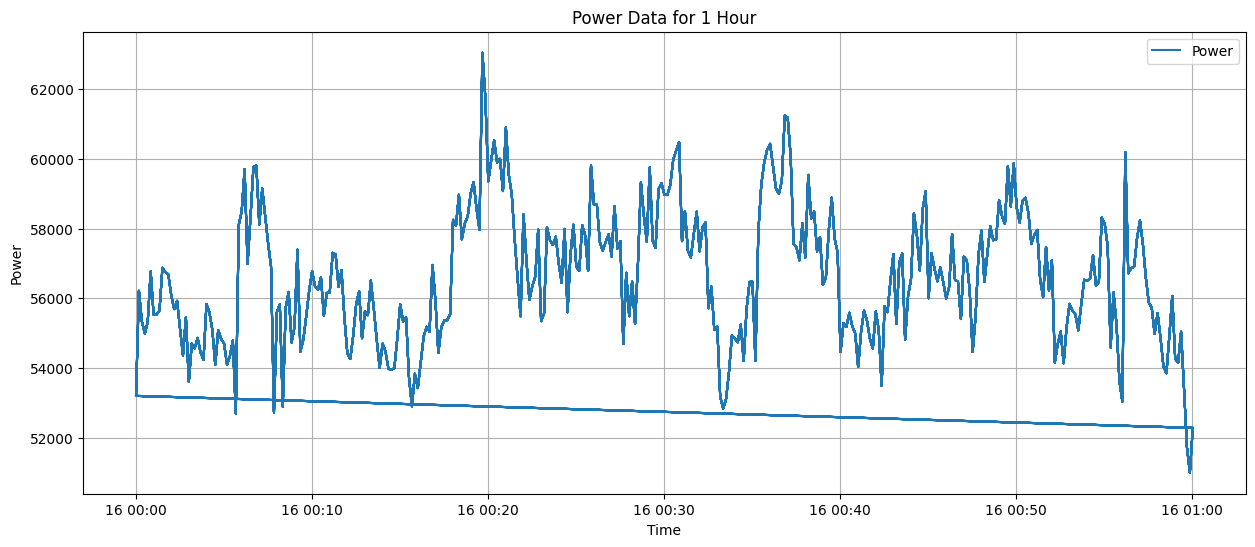

In [22]:
# Filtrer les données pour une heure
data_1hour = data.loc[data.index < data.index[0] + pd.DateOffset(hours=1)]

# Visualiser les données
plt.figure(figsize=(15, 6))
plt.plot(data_1hour.index, data_1hour['power'], label='Power')
plt.xlabel('Time')
plt.ylabel('Power')
plt.title('Power Data for 1 Hour')
plt.legend()
plt.grid(True)
plt.show()

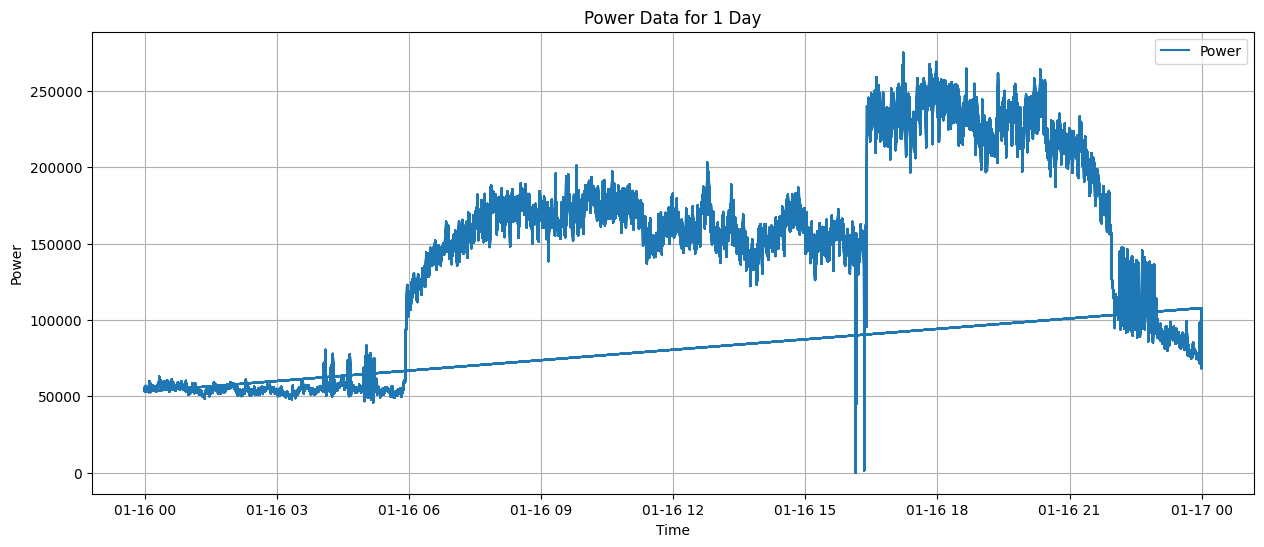

In [23]:
# Filtrer les données pour une journée
data_1day = data.loc[data.index.date == data.index[0].date()]

# Visualiser les données
plt.figure(figsize=(15, 6))
plt.plot(data_1day.index, data_1day['power'], label='Power')
plt.xlabel('Time')
plt.ylabel('Power')
plt.title('Power Data for 1 Day')
plt.legend()
plt.grid(True)
plt.show()

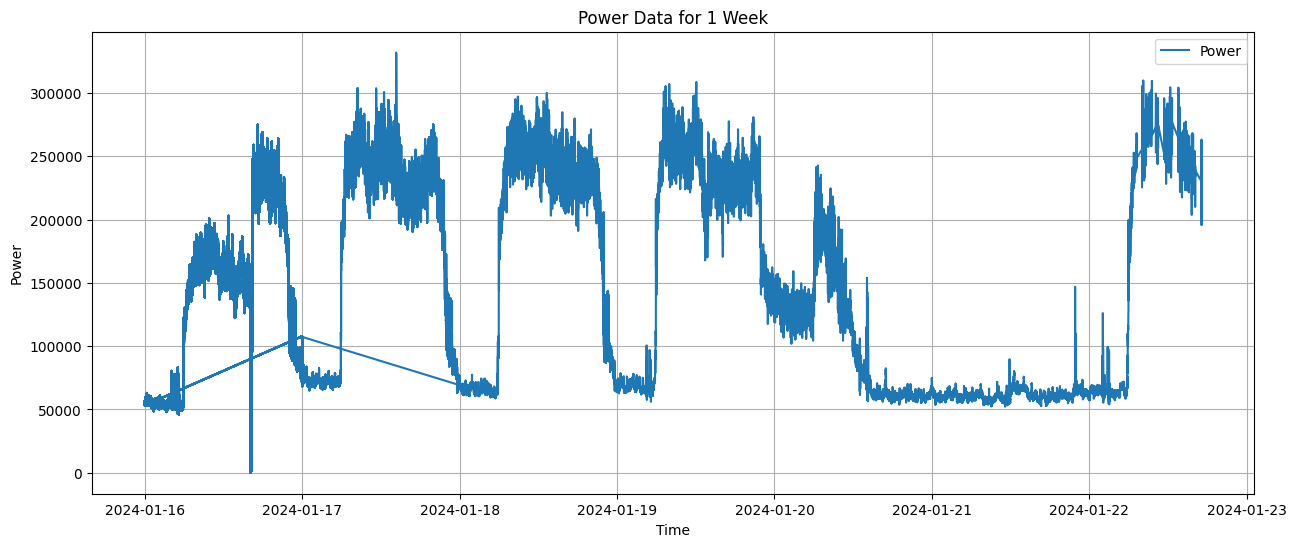

In [24]:
# Filtrer les données pour une semaine
data_1week = data.loc[data.index < data.index[0] + pd.DateOffset(weeks=1)]

# Visualiser les données
plt.figure(figsize=(15, 6))
plt.plot(data_1week.index, data_1week['power'], label='Power')
plt.xlabel('Time')
plt.ylabel('Power')
plt.title('Power Data for 1 Week')
plt.legend()
plt.grid(True)
plt.show()


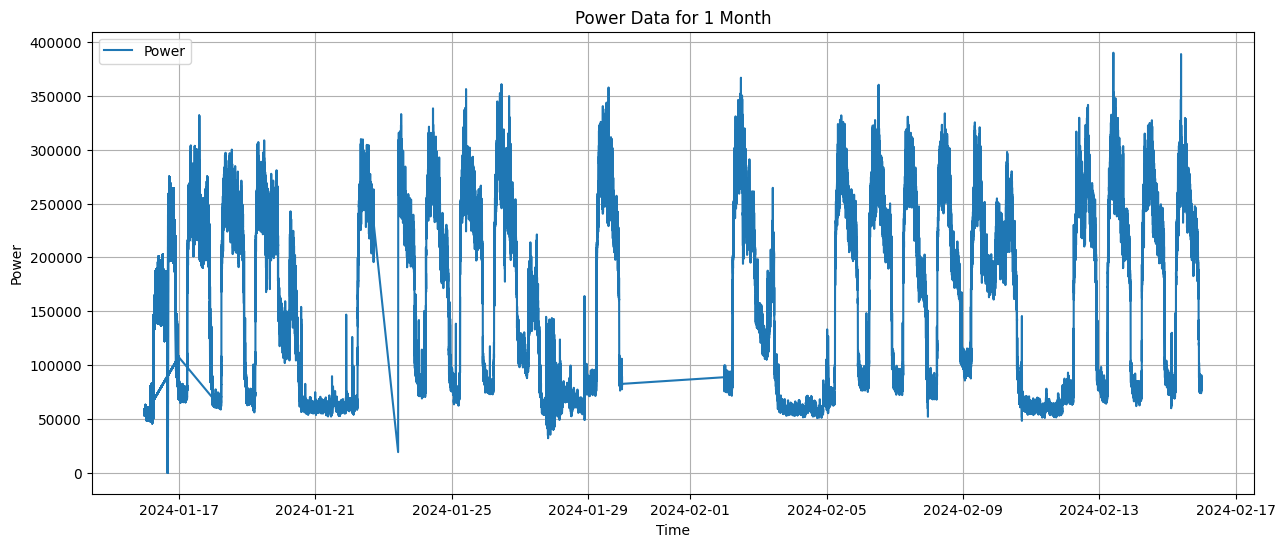

In [25]:
# Filtrer les données pour un mois
data_1month = data.loc[data.index < data.index[0] + pd.DateOffset(months=1)]

# Visualiser les données
plt.figure(figsize=(15, 6))
plt.plot(data_1month.index, data_1month['power'], label='Power')
plt.xlabel('Time')
plt.ylabel('Power')
plt.title('Power Data for 1 Month')
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

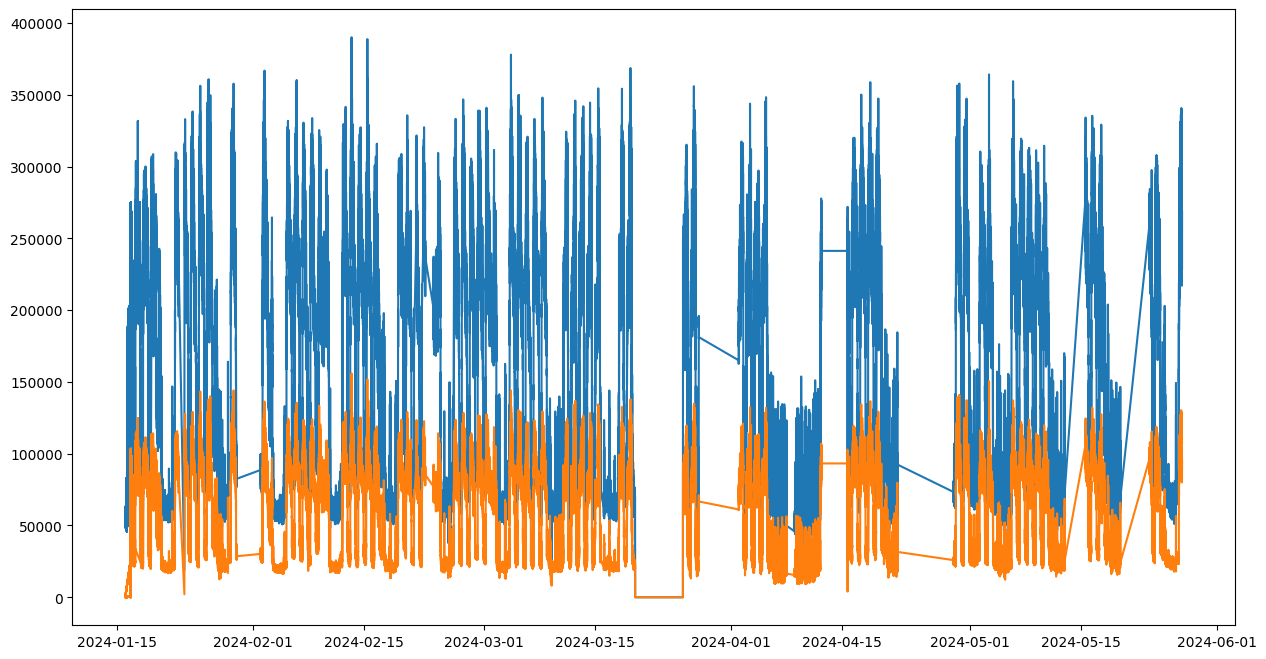

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset (adjust the path to your dataset)
data = pd.read_csv('/kaggle/input/datazero2/output_modified.csv')

# Check if 'time' column exists, convert it to datetime and set as index
if 'time' in data.columns:
    data['time'] = pd.to_datetime(data['time'])
    data = data.set_index('time')
else:
    print("The 'time' column does not exist")

# List of columns to plot
columns_to_plot = ['power', 'power1', 'power2', 'power3']

# Plot selected columns
plt.figure(figsize=(15, 8))
for column in columns_to_plot:
    if column in data.columns:
        plt.plot(data.index, data[column], label=column)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Selected Power Data from DataFrame')
plt.legend()
plt.show()


In [ ]:

# Plot all columns except 'time'
plt.figure(figsize=(15, 8))
for column in data.columns:
    plt.plot(data.index, data[column], label=column)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Data from DataFrame')
plt.legend()
plt.show()


**Analyse de serie temporelle*"Analyse de la décomposition saisonnière de variable power"**

Est-ce un modéle additif ?**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Charger le DataFrame à partir du fichier CSV
file_path = '/kaggle/input/datazero2/output_modified.csv'
df = pd.read_csv(file_path)

# Convertir la colonne 'time' en type datetime et l'utiliser comme index
df['time'] = pd.to_datetime(df['time'])

# Définir l'index sur la colonne 'time'
df.set_index('time', inplace=True)

# Spécifier une période pour la décomposition saisonnière, par exemple 24 pour des données horaires
period = 24

# Effectuer la décomposition saisonnière avec un modèle additif
TSA_additive = seasonal_decompose(df['power'], model='additive', period=period)

# Afficher les composantes  de la décomposition saisonnière
TSA_additive.plot()
plt.show()

Est-ce un modéle multiplicatif ?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Charger le DataFrame à partir du fichier CSV
file_path = '/kaggle/input/datazero2/output_modified.csv'
df = pd.read_csv(file_path)

# Convertir la colonne 'time' en type datetime et l'utiliser comme index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Ajouter une petite constante aux valeurs pour les rendre positives
constant = 1e-8
df['power'] = df['power'] + constant

# Spécifier une période pour la décomposition saisonnière, par exemple 24 pour des données horaires
period = 24

# Effectuer la décomposition saisonnière avec un modèle multiplicatif
TSA_multiplicative = seasonal_decompose(df['power'], model='multiplicative', period=period)

# Afficher les composantes de la décomposition saisonnière
TSA_multiplicative.plot()
plt.show()


**Fonctions pour l'analyse de séries temporelles et modélisation SARIMA**

In [ ]:
# Function to plot ACF and PACF
def plot_acf_pacf(data, lags=7):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    plot_acf(data, lags=lags, ax=ax1)
    plot_pacf(data, lags=lags, ax=ax2)
    plt.show()

# Seasonal decomposition
def seasonal_decompose_plot(data, period=24):
    TSA = seasonal_decompose(data, period=period)
    TSA.plot()

# ADF Test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

# Difference and ACF/PACF
def difference_acf_pacf(data, lags=36):
    diff_power = data.diff().dropna()
    plot_acf_pacf(diff_power, lags=lags)

# Difference with seasonality and ACF/PACF
def seasonal_difference_acf_pacf(data, period=12, lags=36):
    diff_power = data.diff().diff(period).dropna()
    plot_acf_pacf(diff_power, lags=lags)

# SARIMA model
def sarima_model(endog, order=(1,1,1), seasonal_order=(0,0,1,12)):
    model = sm.tsa.SARIMAX(endog, order=order, seasonal_order=seasonal_order)
    sarima = model.fit()
    print(sarima.summary())

**Test ADF**

In [ ]:
#from statsmodels.tsa.stattools import adfuller
#adf_test(data['power'])

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Exemple de réduction de l'échantillon
sample_data = data['power'].sample(1000)

# Exécution du test ADF sur l'échantillon
adf_result = adfuller(sample_data)

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')



****Nous rejetons l'hypothèse nulle du test ADF, ce qui signifie que la série temporelle data['power'] est stationnaire.

**Diffiérenciation + ACF/PACF
utilisés principalement dans l'analyse des séries temporelles pour comprendre les relations et les dépendances temporelles dans les données.
l'ACF et la PACF sont des outils essentiels pour analyser et modéliser les séries temporelles, en aidant à identifier les relations temporelles et à déterminer les paramètres appropriés pour les modèles de prévision.

1)Sans difféerenciation**

In [ ]:
difference_acf_pacf(df['power'])

2)avec differenciation

In [ ]:
seasonal_difference_acf_pacf(df['power'])

avec differencaition  d'ordre 12

 **seasonal_decompose**


In [ ]:
 seasonal_decompose_plot(df['power'])

**lissag exponentiell detection des anomalies a l'aide de fenetre glissent puis trace leur frequence **

In [ ]:
##########version111111111
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fonction pour appliquer le filtre EMA
def apply_ema_filter(data, alpha):
    filtered_data = np.zeros_like(data)
    filtered_data[0] = data[0]  # Initialiser le premier élément
    for i in range(1, len(data)):
        filtered_data[i] = alpha * data[i] + (1 - alpha) * filtered_data[i - 1]
    return filtered_data

# Fonction pour détecter les anomalies basées sur les moyennes glissantes
def check_samples_against_averages(samples, window_average, threshold=0.2):
    anomalies = ["normal" if abs(sample - avg) <= threshold * avg else "abnormal"
                 for sample, avg in zip(samples, window_average) if not np.isnan(avg)]
    # Étendre la liste des anomalies pour correspondre à la longueur des échantillons, en supposant "normal" pour les valeurs initiales NaN
    return ["normal"] * (len(samples) - len(anomalies)) + anomalies

# Charger les données (remplacer le chemin si nécessaire)
data = pd.read_csv('/kaggle/input/datazero2/output_modified.csv')

# Appliquer le lissage EMA aux colonnes spécifiques avec alpha = 0.8
alpha = 0.8
data['smoothed_power'] = apply_ema_filter(data['power'].values, alpha)
data['smoothed_power1'] = apply_ema_filter(data['power1'].values, alpha)
data['smoothed_power2'] = apply_ema_filter(data['power2'].values, alpha)
data['smoothed_power3'] = apply_ema_filter(data['power3'].values, alpha)

# Définir la taille de la fenêtre pour la détection d'anomalies
window_size = 5

# Appliquer la détection d'anomalies sur les données lissées en utilisant la fenêtre glissante
data['mwa_power'] = pd.Series(data['smoothed_power']).rolling(window=window_size).mean()
data['mwa_power1'] = pd.Series(data['smoothed_power1']).rolling(window=window_size).mean()
data['mwa_power2'] = pd.Series(data['smoothed_power2']).rolling(window=window_size).mean()
data['mwa_power3'] = pd.Series(data['smoothed_power3']).rolling(window=window_size).mean()

threshold = 0.10  # Ajuster le seuil pour la détection des anomalies
data['anomaly_power'] = check_samples_against_averages(data['smoothed_power'], data['mwa_power'], threshold)
data['anomaly_power1'] = check_samples_against_averages(data['smoothed_power1'], data['mwa_power1'], threshold)
data['anomaly_power2'] = check_samples_against_averages(data['smoothed_power2'], data['mwa_power2'], threshold)
data['anomaly_power3'] = check_samples_against_averages(data['smoothed_power3'], data['mwa_power3'], threshold)

# Fonction pour tracer les données lissées
def plot_smoothed_data(data, column_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data[column_name], label='Original', alpha=0.5)
    plt.plot(data[f'smoothed_{column_name}'], label='Smoothed (EMA)', alpha=0.8)
    plt.title(f'{column_name.capitalize()} Data with EMA Smoothing')
    plt.xlabel('Index')
    plt.ylabel(column_name.capitalize())
    plt.legend()
    plt.show()

# Fonction pour tracer les anomalies
def plot_anomalies(data, column_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data[f'smoothed_{column_name}'], label='Smoothed (EMA)', alpha=0.8)
    plt.scatter(data.index[data[f'anomaly_{column_name}'] == 'abnormal'], 
                data[f'smoothed_{column_name}'][data[f'anomaly_{column_name}'] == 'abnormal'], 
                color='red', label='Anomalies', zorder=5)
    plt.title(f'Anomalies in {column_name.capitalize()} Data')
    plt.xlabel('Index')
    plt.ylabel(column_name.capitalize())
    plt.legend()
    plt.show()

# Tracer les graphiques pour chaque colonne
for column in ['power', 'power1', 'power2', 'power3']:
    plot_smoothed_data(data, column)
    plot_anomalies(data, column)


In [ ]:
####version2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq

# Définir la fonction pour appliquer le filtre EMA
def apply_ema_filter(data, alpha):
    filtered_data = np.zeros_like(data)
    filtered_data[0] = data[0]  # Initialiser le premier élément
    for i in range(1, len(data)):
        filtered_data[i] = alpha * data[i] + (1 - alpha) * filtered_data[i - 1]
    return filtered_data

# Définir la fonction pour détecter les anomalies basées sur les moyennes glissantes
def check_samples_against_averages(samples, window_average, threshold=0.2):
    anomalies = ["normal" if abs(sample - avg) <= threshold * avg else "abnormal"
                 for sample, avg in zip(samples, window_average) if not np.isnan(avg)]
    # Étendre la liste des anomalies pour correspondre à la longueur des échantillons, en supposant "normal" pour les valeurs initiales NaN
    return ["normal"] * (len(samples) - len(anomalies)) + anomalies

# Charger les données (remplacer le chemin si nécessaire)
data = pd.read_csv('/kaggle/input/datazero2/output_modified.csv')

# Appliquer le lissage EMA aux colonnes spécifiques avec alpha = 0.8
alpha = 0.8
data['smoothed_power'] = apply_ema_filter(data['power'].values, alpha)
data['smoothed_power1'] = apply_ema_filter(data['power1'].values, alpha)
data['smoothed_power2'] = apply_ema_filter(data['power2'].values, alpha)
data['smoothed_power3'] = apply_ema_filter(data['power3'].values, alpha)

# Définir la taille de la fenêtre pour la détection d'anomalies
window_size = 5

# Appliquer la détection d'anomalies sur les données lissées en utilisant la fenêtre glissante
data['mwa_power'] = pd.Series(data['smoothed_power']).rolling(window=window_size).mean()
data['mwa_power1'] = pd.Series(data['smoothed_power1']).rolling(window=window_size).mean()
data['mwa_power2'] = pd.Series(data['smoothed_power2']).rolling(window=window_size).mean()
data['mwa_power3'] = pd.Series(data['smoothed_power3']).rolling(window=window_size).mean()

threshold = 0.10  # Ajuster le seuil pour la détection des anomalies
data['anomaly_power'] = check_samples_against_averages(data['smoothed_power'], data['mwa_power'], threshold)
data['anomaly_power1'] = check_samples_against_averages(data['smoothed_power1'], data['mwa_power1'], threshold)
data['anomaly_power2'] = check_samples_against_averages(data['smoothed_power2'], data['mwa_power2'], threshold)
data['anomaly_power3'] = check_samples_against_averages(data['smoothed_power3'], data['mwa_power3'], threshold)

# Fonction pour tracer les données lissées
def plot_smoothed_data(data, column_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data[column_name], label='Original', alpha=0.5)
    plt.plot(data[f'smoothed_{column_name}'], label='Smoothed (EMA)', alpha=0.8)
    plt.title(f'{column_name.capitalize()} Data with EMA Smoothing')
    plt.xlabel('Index')
    plt.ylabel(column_name.capitalize())
    plt.legend()
    plt.show()

# Fonction pour tracer les anomalies
def plot_anomalies(data, column_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data[f'smoothed_{column_name}'], label='Smoothed (EMA)', alpha=0.8)
    plt.scatter(data.index[data[f'anomaly_{column_name}'] == 'abnormal'], 
                data[f'smoothed_{column_name}'][data[f'anomaly_{column_name}'] == 'abnormal'], 
                color='red', label='Anomalies', zorder=5)
    plt.title(f'Anomalies in {column_name.capitalize()} Data')
    plt.xlabel('Index')
    plt.ylabel(column_name.capitalize())
    plt.legend()
    plt.show()

# Fonction pour tracer les anomalies en fréquence
def plot_anomalies_frequency(data, column_name):
    # Extraire les indices et valeurs anormales
    abnormal_indices = data.index[data[f'anomaly_{column_name}'] == 'abnormal']
    abnormal_values = data[f'smoothed_{column_name}'][data[f'anomaly_{column_name}'] == 'abnormal'].values
    
    # Tracer les anomalies
    plt.figure(figsize=(12, 6))
    plt.plot(abnormal_indices, abnormal_values, 'ro-', label='Abnormal', zorder=5)
    plt.title(f'Anomalous Points in {column_name.capitalize()} Data')
    plt.xlabel('Index')
    plt.ylabel(column_name.capitalize())
    plt.legend()
    plt.show()
    
    # Transformation de Fourier pour analyser les fréquences des anomalies
    n = len(abnormal_values)
    yf = fft(abnormal_values)
    xf = fftfreq(n, 1)  # Période d'échantillonnage de 1 unité

    # Filtrer les fréquences basses et hautes (ex. : couper en dessous de 0.1 et au-dessus de 0.9)
    yf_filtered = np.copy(yf)
    low_cutoff = 0.1
    high_cutoff = 0.9
    yf_filtered[(xf < low_cutoff) | (xf > high_cutoff)] = 0

    # Transformer de nouveau dans le domaine temporel
    filtered_anomalies = ifft(yf_filtered).real

    # Créer un graphique pour les anomalies filtrées
    plt.figure(figsize=(12, 6))
    plt.plot(abnormal_indices, filtered_anomalies, 'go-', label='Filtered Anomalies', zorder=5)
    plt.title(f'Filtered Anomalous Points in {column_name.capitalize()} Data (Frequency Domain)')
    plt.xlabel('Index')
    plt.ylabel('Filtered ' + column_name.capitalize())
    plt.legend()
    plt.show()

# Tracer les graphiques pour chaque colonne
for column in ['power', 'power1', 'power2', 'power3']:
    plot_smoothed_data(data, column)
    plot_anomalies(data, column)
    plot_anomalies_frequency(data, column)


**versionn3**

In [ ]:
# Fonction pour appliquer le filtre EMA
def apply_ema_filter(data, alpha):
    filtered_data = np.zeros_like(data)
    filtered_data[0] = data[0]  # Initialiser le premier élément
    for i in range(1, len(data)):
        filtered_data[i] = alpha * data[i] + (1 - alpha) * filtered_data[i - 1]
    return filtered_data

# Fonction pour appliquer la moyenne glissante
def moving_window_average(data, window_size):
    return data.rolling(window=window_size).mean()


In [ ]:
# Appliquer le lissage EMA aux colonnes spécifiques avec alpha = 0.8
alpha = 0.8
data['smoothed_power'] = apply_ema_filter(data['power'].values, alpha)
data['smoothed_power1'] = apply_ema_filter(data['power1'].values, alpha)
data['smoothed_power2'] = apply_ema_filter(data['power2'].values, alpha)
data['smoothed_power3'] = apply_ema_filter(data['power3'].values, alpha)

# Afficher les premières lignes du DataFrame mis à jour pour vérifier les valeurs lissées
print(data[['power', 'smoothed_power', 'power1', 'smoothed_power1', 'power2', 'smoothed_power2', 'power3', 'smoothed_power3']].head())


In [ ]:
# Définir le chemin pour le fichier CSV des données lissées
smoothed_data_path = './smoothed_datas.csv'

# Sauvegarder les données lissées dans un fichier CSV
smoothed_columns = ['smoothed_power', 'smoothed_power1', 'smoothed_power2', 'smoothed_power3']
data[smoothed_columns].to_csv(smoothed_data_path, index=False)

print(f'Données lissées sauvegardées dans {smoothed_data_path}')


In [ ]:
# Appliquer la moyenne glissante avec une taille de fenêtre de 5
window_size = 5
data['mwa_power'] = moving_window_average(data['smoothed_power'], window_size)
data['mwa_power1'] = moving_window_average(data['smoothed_power1'], window_size)
data['mwa_power2'] = moving_window_average(data['smoothed_power2'], window_size)
data['mwa_power3'] = moving_window_average(data['smoothed_power3'], window_size)

# Afficher les premières lignes du DataFrame mis à jour pour vérifier les moyennes glissantes
data[['smoothed_power', 'mwa_power', 'smoothed_power1', 'mwa_power1', 'smoothed_power2', 'mwa_power2', 'smoothed_power3', 'mwa_power3']].head(10)


In [ ]:
# Définir le chemin pour le fichier CSV des données finales avec les moyennes glissantes
final_data_path = './final_smoothed_data.csv'

# Colonnes à sauvegarder
final_columns = ['mwa_power', 'mwa_power1', 'mwa_power2', 'mwa_power3']

# Sauvegarder les données finales avec les moyennes glissantes dans un fichier CSV
data[final_columns].to_csv(final_data_path, index=False)

print(f'Données finales sauvegardées dans {final_data_path}')


In [ ]:
# Fonction pour détecter les anomalies basées sur les moyennes glissantes
def check_samples_against_averages(samples, window_average, threshold=0.20):
    anomalies = ["normal" if abs(sample - avg) > threshold * avg else "abnormal"
                 for sample, avg in zip(samples, window_average) if not np.isnan(avg)]
    # Étendre la liste des anomalies pour correspondre à la longueur des échantillons, en supposant "normal" pour les valeurs initiales NaN
    return ["normal"] * (len(samples) - len(anomalies)) + anomalies

# Appliquer la détection d'anomalies
threshold = 0.10  # Ajuster le seuil pour la détection des anomalies
data['anomaly_power'] = check_samples_against_averages(data['smoothed_power'], data['mwa_power'], threshold)
data['anomaly_power1'] = check_samples_against_averages(data['smoothed_power1'], data['mwa_power1'], threshold)
data['anomaly_power2'] = check_samples_against_averages(data['smoothed_power2'], data['mwa_power2'], threshold)
data['anomaly_power3'] = check_samples_against_averages(data['smoothed_power3'], data['mwa_power3'], threshold)

# Vérifier les résultats avec les anomalies
data[['power', 'smoothed_power', 'mwa_power', 'anomaly_power']].head(10)


In [ ]:
# Fonction pour tracer les données
def plot_data(data, column_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data[column_name], label='Original', alpha=0.5)
    plt.plot(data[f'smoothed_{column_name}'], label='Smoothed', alpha=0.8)
    plt.plot(data[f'mwa_{column_name}'], label='Moving Window Average', linestyle='--')
    plt.title(f'{column_name.capitalize()} Data')
    plt.xlabel('Index')
    plt.ylabel(column_name.capitalize())
    plt.legend()
    plt.show()

# Tracer chaque colonne
for column in ['power', 'power1', 'power2', 'power3']:
    plot_data(data, column)


In [ ]:
# Définir la fonction pour appliquer le filtre EMA
def apply_ema_filter(data, alpha):
    filtered_data = np.zeros_like(data)
    filtered_data[0] = data[0]  # Initialiser le premier élément
    for i in range(1, len(data)):
        filtered_data[i] = alpha * data[i] + (1 - alpha) * filtered_data[i - 1]
    return filtered_data

# Définir la fonction pour appliquer la moyenne glissante
def moving_window_average(data, window_size):
    return data.rolling(window=window_size).mean()

# Extraire la liste des valeurs de puissance
power_list = list(data["power"])
x_power = np.arange(len(power_list))

# Appliquer le filtre EMA
filtered_power_list = apply_ema_filter(power_list, 0.8)

# Calculer la moyenne glissante avec une fenêtre de 5
mwa_power = moving_window_average(pd.Series(filtered_power_list), window_size=5).values

# Définir la fonction pour détecter les anomalies basées sur les moyennes glissantes
def check_samples_against_averages(samples, window_average, threshold=0.2):
    anomalies = ["normal" if abs(sample - avg) <= threshold * avg else "abnormal"
                 for sample, avg in zip(samples, window_average) if not np.isnan(avg)]
    # Étendre la liste des anomalies pour correspondre à la longueur des échantillons, en supposant "normal" pour les valeurs initiales NaN
    return ["normal"] * (len(samples) - len(anomalies)) + anomalies

# Détecter les anomalies en utilisant les moyennes glissantes calculées
threshold = 0.10  # Ajuster le seuil pour la détection des anomalies
results = check_samples_against_averages(filtered_power_list, mwa_power, threshold)

# Tracer les résultats
plt.figure(figsize=(12, 6))
plt.plot(x_power, filtered_power_list, label="Filtered Power", color='blue')

# Mettre en évidence les échantillons anormaux
abnormal_indices = [i for i, result in enumerate(results) if result == "abnormal"]
abnormal_values = [filtered_power_list[i] for i in abnormal_indices]
plt.scatter(abnormal_indices, abnormal_values, color='red', label='Abnormal', zorder=5)

# Ajouter les titres et légendes
plt.title("Filtered Power with Abnormal Points Highlighted")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq



# Transformation Fourier pour analyser les fréquences des anomalies
def plot_filtered_anomalous_points(abnormal_indices, abnormal_values):
    n = len(abnormal_values)
    yf = fft(abnormal_values)
    xf = fftfreq(n, 1)  # Période d'échantillonnage de 1 unité

    # Filtrer les fréquences basses et hautes (ex. : couper en dessous de 0.1 et au-dessus de 0.9)
    yf_filtered = np.copy(yf)
    low_cutoff = 0.1
    high_cutoff = 0.9
    yf_filtered[(xf < low_cutoff) | (xf > high_cutoff)] = 0

    # Transformer de nouveau dans le domaine temporel
    filtered_anomalies = ifft(yf_filtered).real

    # Créer un graphique pour les anomalies filtrées
    plt.figure(figsize=(12, 6))
    plt.plot(abnormal_indices, filtered_anomalies, 'go-', label='Filtered Anomalies', zorder=5)

    # Ajouter les titres et légendes pour le graphique des anomalies filtrées
    plt.title("Filtered Anomalous Points (Frequency Domain)")
    plt.xlabel("Sample Index")
    plt.ylabel("Filtered Power")
    plt.legend()
    plt.show()

# Appeler la fonction pour tracer les points anormaux filtrés
abnormal_indices = [i for i, result in enumerate(results) if result == "abnormal"]
abnormal_values = [filtered_power_list[i] for i in abnormal_indices]
plot_filtered_anomalous_points(abnormal_indices, abnormal_values)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import matplotlib.pyplot as plt

# Charger les données depuis le fichier CSV
data_path = '/kaggle/input/datazero2/output_modified.csv'
df = pd.read_csv(data_path)

# Assurer que la colonne 'time' est au format datetime
df['time'] = pd.to_datetime(df['time'])

# Fonction pour préparer les séquences temporelles
def prepare_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Fonction pour détecter les anomalies
def detect_anomalies(data, threshold=2):
    mean = np.mean(data)
    std = np.std(data)
    abnormal_indices = np.where(np.abs(data - mean) > threshold * std)[0]
    abnormal_values = data[abnormal_indices]
    return abnormal_values, abnormal_indices

# Fonction pour entraîner le modèle et tracer les résultats
def process_power_column(df, column_name, window_size=10):
    # Sélectionner la variable de temps et la série temporelle à prévoir
    time_series = df['time']
    target_variable = df[column_name]

    # Normaliser les données
    target_variable = (target_variable - target_variable.mean()) / target_variable.std()

    # Préparer les données en séquences temporelles
    X, y = prepare_sequences(target_variable.values, window_size)

    # Diviser les données en ensembles d'entraînement et de test
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Reshape les données pour qu'elles soient compatibles avec le modèle GRU
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Enregistrer l'heure de début
    start_time = time.time()

    # Définir le modèle GRU
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(64, input_shape=(window_size, 1)),
        tf.keras.layers.Dense(1)
    ])

    # Compiler le modèle
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Définir l'early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Ajuster le modèle aux données d'entraînement
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # Prévoir les valeurs futures
    forecast = model.predict(X_test)

    # Enregistrer l'heure de fin
    end_time = time.time()

    # Calculer le temps d'exécution en secondes
    execution_time = end_time - start_time

    # Calcul des métriques
    mae = mean_absolute_error(y_test, forecast)
    rmse = np.sqrt(mean_squared_error(y_test, forecast))

    # Afficher les métriques
    print(f"Metrics for {column_name}")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("Temps d'exécution (TT) en secondes:", execution_time)

    # Détecter les anomalies dans l'ensemble de test
    abnormal_values, abnormal_indices = detect_anomalies(y_test)

    # Convertir les indices des anomalies en indices temporels
    abnormal_time_indices = df['time'][split + window_size + abnormal_indices]

    # Tracer les vraies valeurs par rapport aux prédictions
    plt.figure(figsize=(10, 6))
    plt.plot(df['time'][split + window_size:], y_test, label='Vraies valeurs')
    plt.plot(df['time'][split + window_size:], forecast, label='Prédictions')

    # Ajouter des points rouges pour les anomalies
    plt.scatter(abnormal_time_indices, abnormal_values, color='red', label='Anomalies')

    plt.xlabel('Temps')
    plt.ylabel(f'{column_name} (Normalisé)')
    plt.title(f'Vraies valeurs vs Prédictions pour {column_name}')
    plt.legend()
    plt.show()

# Exemple d'utilisation
for column in ['power', 'power1', 'power2', 'power3']:
    process_power_column(df, column)

**test de code**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt

# Charger les données depuis le fichier CSV
data_path = '/kaggle/input/datazero2/output_modified.csv'
df = pd.read_csv(data_path)

# Assurer que la colonne 'time' est au format datetime
df['time'] = pd.to_datetime(df['time'])

# Fonction pour préparer les séquences temporelles
def prepare_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Fonction pour détecter les anomalies
def detect_anomalies(data, threshold=2):
    mean = np.mean(data)
    std = np.std(data)
    abnormal_indices = np.where(np.abs(data - mean) > threshold * std)[0]
    abnormal_values = data[abnormal_indices]
    return abnormal_values, abnormal_indices

# Fonction pour entraîner le modèle et tracer les résultats
def process_power_column(df, column_name, window_size=10):
    # Sélectionner la variable de temps et la série temporelle à prévoir
    time_series = df['time']
    target_variable = df[column_name].values.reshape(-1, 1)

    # Normaliser les données pour qu'elles soient entre 0 et 1
    scaler = MinMaxScaler()
    target_variable = scaler.fit_transform(target_variable)

    # Préparer les données en séquences temporelles
    X, y = prepare_sequences(target_variable, window_size)

    # Diviser les données en ensembles d'entraînement et de test
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Reshape les données pour qu'elles soient compatibles avec le modèle GRU
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Enregistrer l'heure de début
    start_time = time.time()

    # Définir le modèle GRU
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(64, return_sequences=True, input_shape=(window_size, 1)),
        tf.keras.layers.GRU(32),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    # Compiler le modèle
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Définir l'early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Ajuster le modèle aux données d'entraînement
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # Prévoir les valeurs futures
    forecast = model.predict(X_test)

    # Inverser la normalisation pour les prédictions et les vraies valeurs
    forecast = scaler.inverse_transform(forecast)
    y_test = scaler.inverse_transform(y_test)

    # Enregistrer l'heure de fin
    end_time = time.time()

    # Calculer le temps d'exécution en secondes
    execution_time = end_time - start_time

    # Calcul des métriques
    mae = mean_absolute_error(y_test, forecast)
    rmse = np.sqrt(mean_squared_error(y_test, forecast))

    # Afficher les métriques
    print(f"Metrics for {column_name}")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("Temps d'exécution (TT) en secondes:", execution_time)

    # Détecter les anomalies dans l'ensemble de test
    abnormal_values, abnormal_indices = detect_anomalies(y_test.flatten())

    # Convertir les indices des anomalies en indices temporels
    abnormal_time_indices = df['time'][split + window_size + abnormal_indices]

    # Tracer les vraies valeurs par rapport aux prédictions
    plt.figure(figsize=(10, 6))
    plt.plot(df['time'][split + window_size:], y_test, label='Vraies valeurs')
    plt.plot(df['time'][split + window_size:], forecast, label='Prédictions')

    # Ajouter des points rouges pour les anomalies
    plt.scatter(abnormal_time_indices, abnormal_values, color='red', label='Anomalies')

    plt.xlabel('Temps')
    plt.ylabel(f'{column_name}')
    plt.title(f'Vraies valeurs vs Prédictions pour {column_name}')
    plt.legend()
    plt.show()

    # Tracer les graphes de loss et val_loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.title('Perte et Perte de validation au cours de l\'entraînement')
    plt.legend()
    plt.show()

# Exemple d'utilisation
for column in ['power', 'power1', 'power2', 'power3']:
    process_power_column(df, column)


2024-07-25 18:22:47.756763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 18:22:47.756887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 18:22:48.057380: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/50
18994/18994 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - loss: 5.8589e-04 - val_loss: 2.9047e-04
Epoch 2/50
18994/18994 ━━━━━━━━━━━━━━━━━━━━ 113s 6ms/step - loss: 2.4747e-04 - val_loss: 2.9707e-04
Epoch 3/50
 4561/18994 ━━━━━━━━━━━━━━━━━━━━ 1:19 5ms/step - loss: 2.2599e-04

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt

# Charger les données depuis le fichier CSV
data_path = '/kaggle/input/datazero2/output_modified.csv'
df = pd.read_csv(data_path)

# Assurer que la colonne 'time' est au format datetime
df['time'] = pd.to_datetime(df['time'])

# Fonction pour préparer les séquences temporelles
def prepare_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Fonction pour détecter les anomalies
def detect_anomalies(data, threshold=2):
    mean = np.mean(data)
    std = np.std(data)
    abnormal_indices = np.where(np.abs(data - mean) > threshold * std)[0]
    abnormal_values = data[abnormal_indices]
    return abnormal_values, abnormal_indices

# Fonction pour entraîner le modèle et tracer les résultats
def process_power_column(df, column_name, window_size=10):
    # Sélectionner la variable de temps et la série temporelle à prévoir
    time_series = df['time']
    target_variable = df[column_name].values.reshape(-1, 1)

    # Normaliser les données pour qu'elles soient entre 0 et 1
    scaler = MinMaxScaler()
    target_variable = scaler.fit_transform(target_variable)

    # Préparer les données en séquences temporelles
    X, y = prepare_sequences(target_variable, window_size)

    # Diviser les données en ensembles d'entraînement et de test
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Reshape les données pour qu'elles soient compatibles avec le modèle GRU
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Enregistrer l'heure de début
    start_time = time.time()

    # Définir le modèle GRU
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(64, input_shape=(window_size, 1)),
        tf.keras.layers.Dense(1)
    ])

    # Compiler le modèle
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Définir l'early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Ajuster le modèle aux données d'entraînement
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # Prévoir les valeurs futures
    forecast = model.predict(X_test)

    # Inverser la normalisation pour les prédictions et les vraies valeurs
    forecast = scaler.inverse_transform(forecast)
    y_test = scaler.inverse_transform(y_test)

    # Enregistrer l'heure de fin
    end_time = time.time()

    # Calculer le temps d'exécution en secondes
    execution_time = end_time - start_time

    # Calcul des métriques
    mae = mean_absolute_error(y_test, forecast)
    rmse = np.sqrt(mean_squared_error(y_test, forecast))

    # Afficher les métriques
    print(f"Metrics for {column_name}")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("Temps d'exécution (TT) en secondes:", execution_time)

    # Détecter les anomalies dans l'ensemble de test
    abnormal_values, abnormal_indices = detect_anomalies(y_test.flatten())

    # Convertir les indices des anomalies en indices temporels
    abnormal_time_indices = df['time'][split + window_size + abnormal_indices]

    # Tracer les vraies valeurs par rapport aux prédictions
    plt.figure(figsize=(10, 6))
    plt.plot(df['time'][split + window_size:], y_test, label='Vraies valeurs')
    plt.plot(df['time'][split + window_size:], forecast, label='Prédictions')

    # Ajouter des points rouges pour les anomalies
    plt.scatter(abnormal_time_indices, abnormal_values, color='red', label='Anomalies')

    plt.xlabel('Temps')
    plt.ylabel(f'{column_name}')
    plt.title(f'Vraies valeurs vs Prédictions pour {column_name}')
    plt.legend()
    plt.show()

    # Tracer les graphes de loss et val_loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.title('Perte et Perte de validation au cours de l\'entraînement')
    plt.legend()
    plt.show()

# Exemple d'utilisation
for column in ['power', 'power1', 'power2', 'power3']:
    process_power_column(df, column)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import matplotlib.pyplot as plt

# Charger les données depuis le fichier CSV
data_path = '/kaggle/input/csv10sec5m/output_cleaned.csv'
df = pd.read_csv(data_path)

# Assurer que la colonne 'time' est au format datetime
df['time'] = pd.to_datetime(df['time'])

# Fonction pour préparer les séquences temporelles
def prepare_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Fonction pour détecter les anomalies
def detect_anomalies(data, threshold=2):
    mean = np.mean(data)
    std = np.std(data)
    abnormal_indices = np.where(np.abs(data - mean) > threshold * std)[0]
    abnormal_values = data[abnormal_indices]
    return abnormal_values, abnormal_indices

# Fonction pour entraîner le modèle et tracer les résultats
def process_power_column(df, column_name, window_size=10):
    # Sélectionner la variable de temps et la série temporelle à prévoir
    time_series = df['time']
    target_variable = df[column_name]

    # Normaliser les données
    target_variable = (target_variable - target_variable.mean()) / target_variable.std()

    # Préparer les données en séquences temporelles
    X, y = prepare_sequences(target_variable.values, window_size)

    # Diviser les données en ensembles d'entraînement et de test
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Reshape les données pour qu'elles soient compatibles avec le modèle GRU
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Enregistrer l'heure de début
    start_time = time.time()

    # Définir le modèle GRU
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(64, input_shape=(window_size, 1)),
        tf.keras.layers.Dense(1)
    ])

    # Compiler le modèle
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Définir l'early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Ajuster le modèle aux données d'entraînement
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # Sauvegarde du modèle au format .h5
    model.save(f'{column_name}_model.h5')
    print(f"Modèle {column_name} sauvegardé au format .h5")

    # Sauvegarde du modèle en TensorFlow SavedModel
    tf.saved_model.save(model, f'{column_name}_saved_model')
    print(f"Modèle {column_name} sauvegardé en TensorFlow SavedModel")

    # Prévoir les valeurs futures
    forecast = model.predict(X_test)

    # Enregistrer l'heure de fin
    end_time = time.time()

    # Calculer le temps d'exécution en secondes
    execution_time = end_time - start_time

    # Calcul des métriques
    mae = mean_absolute_error(y_test, forecast)
    rmse = np.sqrt(mean_squared_error(y_test, forecast))

    # Afficher les métriques
    print(f"Metrics for {column_name}")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("Temps d'exécution (TT) en secondes:", execution_time)

    # Détecter les anomalies dans l'ensemble de test
    abnormal_values, abnormal_indices = detect_anomalies(y_test)

    # Convertir les indices des anomalies en indices temporels
    abnormal_time_indices = df['time'][split + window_size + abnormal_indices]

    # Tracer les vraies valeurs par rapport aux prédictions
    plt.figure(figsize=(10, 6))
    plt.plot(df['time'][split + window_size:], y_test, label='Vraies valeurs')
    plt.plot(df['time'][split + window_size:], forecast, label='Prédictions')

    # Ajouter des points rouges pour les anomalies
    plt.scatter(abnormal_time_indices, abnormal_values, color='red', label='Anomalies')

    plt.xlabel('Temps')
    plt.ylabel(f'{column_name} (Normalisé)')
    plt.title(f'Vraies valeurs vs Prédictions pour {column_name}')
    plt.legend()
    plt.show()

# Exemple d'utilisation
for column in ['power', 'power1', 'power2', 'power3']:
    process_power_column(df, column)


In [ ]:
import shutil
import os

# Fonction pour compresser les répertoires de modèles sauvegardés
def compress_model(model_name):
    shutil.make_archive(f'{model_name}_model', 'zip', f'{model_name}_saved_model')
    print(f'Compressed {model_name}_saved_model to {model_name}_model.zip')

# Fonction pour copier les fichiers si nécessaire
def copy_file(src, dest):
    if os.path.exists(src):
        if os.path.abspath(src) != os.path.abspath(dest):
            shutil.copy(src, dest)
            print(f'Copied {src} to {dest}')
        else:
            print(f'Skipped copying {src} to {dest} (same file)')
    else:
        print(f'Source file {src} does not exist')

# Compresser les fichiers de modèles sauvegardés
compress_model('power')
compress_model('power1')
compress_model('power2')
compress_model('power3')

# Ajouter les fichiers .h5 et les archives zip en tant que fichiers de sortie
copy_file('power_model.h5', '/kaggle/working/power_model.h5')
copy_file('power1_model.h5', '/kaggle/working/power1_model.h5')
copy_file('power2_model.h5', '/kaggle/working/power2_model.h5')
copy_file('power3_model.h5', '/kaggle/working/power3_model.h5')

copy_file('power_model.zip', '/kaggle/working/power_model.zip')
copy_file('power1_model.zip', '/kaggle/working/power1_model.zip')
copy_file('power2_model.zip', '/kaggle/working/power2_model.zip')
copy_file('power3_model.zip', '/kaggle/working/power3_model.zip')


In [ ]:
import shutil
import os

# Fonction pour compresser les répertoires de modèles sauvegardés
def compress_model(model_name):
    shutil.make_archive(f'{model_name}_model', 'zip', f'{model_name}_saved_model')

# Fonction pour copier les fichiers si nécessaire
def copy_file(src, dest):
    # Vérifier si le fichier source et le fichier de destination sont différents
    if os.path.abspath(src) != os.path.abspath(dest):
        shutil.copy(src, dest)

# Compresser les fichiers de modèles sauvegardés
compress_model('power')
compress_model('power1')
compress_model('power2')
compress_model('power3')

# Ajouter les fichiers .h5 et les archives zip en tant que fichiers de sortie
copy_file('power_model.h5', '/kaggle/working/power_model.h5')
copy_file('power1_model.h5', '/kaggle/working/power1_model.h5')
copy_file('power2_model.h5', '/kaggle/working/power2_model.h5')
copy_file('power3_model.h5', '/kaggle/working/power3_model.h5')

copy_file('power_model.zip', '/kaggle/working/power_model.zip')
copy_file('power1_model.zip', '/kaggle/working/power1_model.zip')
copy_file('power2_model.zip', '/kaggle/working/power2_model.zip')
copy_file('power3_model.zip', '/kaggle/working/power3_model.zip')


**extraction des données**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq

# Définir la fonction pour appliquer le filtre EMA
def apply_ema_filter(data, alpha):
 filtered_data = np.zeros_like(data)
 filtered_data[0] = data[0] # Initialiser le premier élément
 for i in range(1, len(data)):
 filtered_data[i] = alpha * data[i] + (1 - alpha) * filtered_data[i - 1]
 return filtered_data

# Définir la fonction pour appliquer la moyenne glissante
def moving_window_average(data, window_size):
 return data.rolling(window=window_size).mean()


# Extraire la liste des valeurs de puissance
power_list = list(data["power"])
x_power = np.arange(len(power_list))

# Appliquer le filtre EMA
filtered_power_list = apply_ema_filter(power_list, 0.8)

# Calculer la moyenne glissante avec une fenêtre de 5
mwa_power = moving_window_average(pd.Series(filtered_power_list), window_size=5).values

# Définir la fonction pour détecter les anomalies basées sur les moyennes glissantes
def check_samples_against_averages(samples, window_average, threshold=0.10):
 anomalies = ["normal" if abs(sample - avg) <= threshold * avg else "abnormal"
 for sample, avg in zip(samples, window_average) if not np.isnan(avg)]
 # Étendre la liste des anomalies pour correspondre à la longueur des échantillons, en supposant "normal" pour les valeurs initiales NaN
 return ["normal"] * (len(samples) - len(anomalies)) + anomalies

# Détecter les anomalies en utilisant les moyennes glissantes calculées
threshold = 0.10 # Ajuster le seuil pour la détection des anomalies
results = check_samples_against_averages(filtered_power_list, mwa_power, threshold)

# Tracer les résultats
plt.figure(figsize=(12, 6))
plt.plot(x_power, filtered_power_list, label="Filtered Power", color='blue')

# Mettre en évidence les échantillons anormaux
abnormal_indices = [i for i, result in enumerate(results) if result == "abnormal"]
abnormal_values = [filtered_power_list[i] for i in abnormal_indices]
plt.scatter(abnormal_indices, abnormal_values, color='red', label='Abnormal', zorder=5)

# Ajouter les titres et légendes
plt.title("Filtered Power with Abnormal Points Highlighted")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.legend()
plt.show()

# Créer un deuxième graphique pour les points anormaux uniquement
plt.figure(figsize=(12, 6))
plt.plot(abnormal_indices, abnormal_values, 'ro-', label='Abnormal', zorder=5)

# Ajouter les titres et légendes pour le graphique des anomalies
plt.title("Anomalous Points")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.legend()
plt.show()

# Transformation Fourier pour analyser les fréquences des anomalies
n = len(abnormal_values)
yf = fft(abnormal_values)
xf = fftfreq(n, 1) # Période d'échantillonnage de 1 unité

# Filtrer les fréquences basses et hautes (ex. : couper en dessous de 0.1 et au-dessus de 0.9)
yf_filtered = np.copy(yf)
low_cutoff = 0.1
high_cutoff = 0.9
yf_filtered[(xf < low_cutoff) | (xf > high_cutoff)] = 0

# Transformer de nouveau dans le domaine temporel
filtered_anomalies = ifft(yf_filtered).real

# Créer un troisième graphique pour les anomalies filtrées
plt.figure(figsize=(12, 6))
plt.plot(abnormal_indices, filtered_anomalies, 'go-', label='Filtered Anomalies', zorder=5)

# Ajouter les titres et légendes pour le graphique des anomalies filtrées
plt.title("Filtered Anomalous Points (Frequency Domain)")
plt.xlabel("Sample Index")
plt.ylabel("Filtered Power")
plt.legend()
plt.show()